In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pickle
from matplotlib import colors
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency
from statsmodels.tools.eval_measures import aic, bic
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = Path('data/appartments_train.csv')

In [5]:
df = pd.read_csv(file_path, sep=',')

In [7]:
df.head()

unit_id  obj_type  dim_m2  n_rooms  floor_no  floor_max  \
0  a3a463617a5c0439  0d6c4dfc   45.89      2.0       1.0        4.0   
1  23a92531fcb238b4  0c238f18   27.64      1.0       1.0        2.0   
2  d158671401f9fc34  0d6c4dfc   62.18      2.0       1.0        2.0   
3  280aced4655b7a96  2a6d5c01   53.68      2.0       NaN        4.0   
4  2315fa621e746fe4  2a6d5c01   70.89      3.0       2.0        3.0   

   year_built  dist_centre  n_poi  dist_sch  ...     price_z  src_month  \
0      1999.0       13.496   11.0     0.541  ...   519626.21    2023-09   
1      1940.0        2.440   16.0     0.377  ...   162959.26    2024-04   
2      2000.0       10.284    8.0     0.391  ...  1167571.51    2023-10   
3      2018.0       10.589   30.0     0.729  ...   907071.16    2024-01   
4      2015.0        8.305    7.0     1.226  ...  1080383.19    2023-11   

   loc_code  market_volatility  infrastructure_quality  \
0  693f303c          501710.76                   14.02   
1  8d5a4f0c          147763.87                  110.55   
2  693f303c         1042847.59                   31.15   
3  693f303c          728839.39                    7.52   
4  693f303c         1263171.15                   11.20   

   neighborhood_crime_rate popularity_index green_space_ratio  \
0                    95.39            44.51             0.999   
1                    46.17            56.25             1.000   
2                    18.94            50.36             0.999   
3                    11.84            46.69             0.999   
4                    89.64            45.60             0.999   

  estimated_maintenance_cost global_economic_index  
0                      13.99            100.291946  
1                       7.59             91.315644  
2                      21.14             93.681619  
3                       7.91             94.192062  
4                       8.63             96.166051  

[5 rows x 34 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156454 entries, 0 to 156453
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   unit_id                     156454 non-null  object 
 1   obj_type                    122634 non-null  object 
 2   dim_m2                      156454 non-null  float64
 3   n_rooms                     156454 non-null  float64
 4   floor_no                    128756 non-null  float64
 5   floor_max                   154533 non-null  float64
 6   year_built                  130741 non-null  float64
 7   dist_centre                 156454 non-null  float64
 8   n_poi                       156454 non-null  float64
 9   dist_sch                    156324 non-null  float64
 10  dist_clinic                 155883 non-null  float64
 11  dist_post                   156266 non-null  float64
 12  dist_kind                   156291 non-null  float64
 13  dist_rest     

In [13]:
columns_with_missings = df.columns[df.isnull().any()]

In [15]:
df[columns_with_missings].isnull().sum()

obj_type                   33820
floor_no                   27698
floor_max                   1921
year_built                 25713
dist_sch                     130
dist_clinic                  571
dist_post                    188
dist_kind                    163
dist_rest                    391
dist_uni                    4317
dist_pharma                  219
build_mat                  61999
cond_class                117058
has_lift                    7727
infrastructure_quality     25713
dtype: int64

In [17]:
# frequency tables for these columns
print('Frequency counts for obj_type: \n')
print(df['obj_type'].value_counts(dropna=False))

Frequency counts for obj_type: 

obj_type
0d6c4dfc    73136
NaN         33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64


In [19]:
'''
Treat NaN as a separate category (e.g., "Unknown" or "Missing") rather than 
dropping or imputing. This keeps data and avoids losing info.
'''

'\nTreat NaN as a separate category (e.g., "Unknown" or "Missing") rather than \ndropping or imputing. This keeps data and avoids losing info.\n'

In [21]:
# frequency tables for these columns
print('Frequency counts for floor_no: \n')
print(df['floor_no'].value_counts(dropna=False))

Frequency counts for floor_no: 

floor_no
1.0     30396
NaN     27698
3.0     27034
2.0     26939
4.0     19173
5.0      7361
6.0      4481
7.0      3521
8.0      2710
9.0      2336
10.0     2224
11.0      902
12.0      508
14.0      334
13.0      258
15.0      206
17.0      155
16.0       92
20.0       25
18.0       25
24.0       19
29.0       14
23.0       14
22.0       11
25.0        6
21.0        6
19.0        5
27.0        1
Name: count, dtype: int64


In [23]:
'''
Do NOT drop NaNs (27,698 missing is large).

Impute NaNs with a special value (e.g., -1) or create a "Missing" indicator feature.

Floor is numeric and likely impacts price, so keep it.

Consider capping very high floors or grouping rare high floors into one category 
to reduce noise.
'''

'\nDo NOT drop NaNs (27,698 missing is large).\n\nImpute NaNs with a special value (e.g., -1) or create a "Missing" indicator feature.\n\nFloor is numeric and likely impacts price, so keep it.\n\nConsider capping very high floors or grouping rare high floors into one category \nto reduce noise.\n'

In [25]:
# frequency tables for these columns
print('Frequency counts for floor_max: \n')
print(df['floor_max'].value_counts(dropna=False))

Frequency counts for floor_max: 

floor_max
4.0     48935
3.0     28889
5.0     15378
10.0    14002
2.0     12042
6.0      8590
7.0      5662
8.0      4533
11.0     4199
1.0      3556
9.0      2049
NaN      1921
12.0     1712
15.0     1176
17.0      930
16.0      790
13.0      691
14.0      548
18.0      191
23.0      111
19.0      106
24.0       97
22.0       84
20.0       61
25.0       58
27.0       53
29.0       35
26.0       24
28.0       18
21.0       13
Name: count, dtype: int64


In [27]:
'''
Small amount of NaNs (1,921), so impute with median (around 4 or 5).

Keep as numeric feature since it likely affects price.

No need to create missing category here due to low missingness.
'''

'\nSmall amount of NaNs (1,921), so impute with median (around 4 or 5).\n\nKeep as numeric feature since it likely affects price.\n\nNo need to create missing category here due to low missingness.\n'

In [29]:
# frequency tables for these columns
print('Frequency counts for year_built: \n')
print(df['year_built'].value_counts(dropna=False))

Frequency counts for year_built: 

year_built
NaN       25713
2023.0     7528
2022.0     6263
1980.0     5432
1970.0     5293
          ...  
1884.0        2
1861.0        2
1855.0        2
1864.0        1
1866.0        1
Name: count, Length: 166, dtype: int64


In [31]:
'''
High NaNs (25,713), impute with median year or a placeholder (e.g., 1900) if many old buildings.

Alternatively, create a "Missing" flag to capture missingness effect.

Keep as numeric (maybe also create age = current_year - year_built).
'''

'\nHigh NaNs (25,713), impute with median year or a placeholder (e.g., 1900) if many old buildings.\n\nAlternatively, create a "Missing" flag to capture missingness effect.\n\nKeep as numeric (maybe also create age = current_year - year_built).\n'

In [33]:
# frequency tables for these columns
print('Frequency counts for dist_sch: \n')
print(df['dist_sch'].value_counts(dropna=False))

Frequency counts for dist_sch: 

dist_sch
0.155    403
0.145    401
0.179    399
0.205    394
0.174    392
        ... 
1.608      1
3.372      1
3.250      1
2.618      1
2.908      1
Name: count, Length: 3613, dtype: int64


In [35]:
'''
Very few missing (130), so impute with median or mean.

Keep as numeric feature.
'''

'\nVery few missing (130), so impute with median or mean.\n\nKeep as numeric feature.\n'

In [37]:
# frequency tables for these columns
print('Frequency counts for dist_clinic: \n')
print(df['dist_clinic'].value_counts(dropna=False))

Frequency counts for dist_clinic: 

dist_clinic
NaN      571
0.303    190
0.299    181
0.271    174
0.294    172
        ... 
4.425      1
4.691      1
4.962      1
4.742      1
4.975      1
Name: count, Length: 4909, dtype: int64


In [39]:
'''
Moderate missing (571), impute with median.

Keep as numeric feature.
'''

'\nModerate missing (571), impute with median.\n\nKeep as numeric feature.\n'

In [41]:
# frequency tables for these columns
print('Frequency counts for dist_post: \n')
print(df['dist_post'].value_counts(dropna=False))

Frequency counts for dist_post: 

dist_post
0.261    304
0.245    293
0.284    289
0.209    285
0.252    284
        ... 
4.431      1
2.802      1
5.045      1
3.602      1
2.081      1
Name: count, Length: 3801, dtype: int64


In [43]:
'''
Few missing (188), impute with median.

Keep as numeric feature.
'''

'\nFew missing (188), impute with median.\n\nKeep as numeric feature.\n'

In [45]:
# frequency tables for these columns
print('Frequency counts for dist_kind: \n')
print(df['dist_kind'].value_counts(dropna=False))

Frequency counts for dist_kind: 

dist_kind
0.161    442
0.158    441
0.112    435
0.173    433
0.141    433
        ... 
2.314      1
4.366      1
2.661      1
3.959      1
3.646      1
Name: count, Length: 3574, dtype: int64


In [47]:
'''
Very few missing (163), impute with median.

Keep as numeric feature.
'''

'\nVery few missing (163), impute with median.\n\nKeep as numeric feature.\n'

In [49]:
# frequency tables for these columns
print('Frequency counts for dist_rest: \n')
print(df['dist_rest'].value_counts(dropna=False))

Frequency counts for dist_rest: 

dist_rest
0.061    480
0.065    475
0.068    470
0.066    470
0.070    463
        ... 
2.420      1
3.823      1
3.027      1
2.071      1
2.856      1
Name: count, Length: 3557, dtype: int64


In [51]:
'''
Moderate missing (391), impute with median.

Keep as numeric feature.
'''

'\nModerate missing (391), impute with median.\n\nKeep as numeric feature.\n'

In [53]:
# frequency tables for these columns
print('Frequency counts for dist_uni: \n')
print(df['dist_uni'].value_counts(dropna=False))

Frequency counts for dist_uni: 

dist_uni
NaN      4317
0.485     124
0.588     110
0.523     110
0.323     109
         ... 
5.694       1
5.744       1
5.603       1
5.217       1
5.310       1
Name: count, Length: 5539, dtype: int64


In [55]:
'''
High missing (4,317), impute with median.

Optionally add missing indicator.

Keep numeric.
'''

'\nHigh missing (4,317), impute with median.\n\nOptionally add missing indicator.\n\nKeep numeric.\n'

In [57]:
# frequency tables for these columns
print('Frequency counts for dist_pharma: \n')
print(df['dist_pharma'].value_counts(dropna=False))

Frequency counts for dist_pharma: 

dist_pharma
0.167    486
0.133    472
0.165    464
0.156    463
0.163    462
        ... 
3.589      1
4.605      1
2.716      1
4.061      1
3.973      1
Name: count, Length: 3583, dtype: int64


In [59]:
'''
Few missing (219), impute with median.

Keep numeric.
'''

'\nFew missing (219), impute with median.\n\nKeep numeric.\n'

In [61]:
# frequency tables for these columns
print('Frequency counts for build_mat: \n')
print(df['build_mat'].value_counts(dropna=False))

Frequency counts for build_mat: 

build_mat
7ceffe3b    73414
NaN         61999
7f8c00f9    21041
Name: count, dtype: int64


In [63]:
'''
Large NaNs (61,999), so treat NaN as separate category ("Missing").

Encode all categories (including "Missing") with one-hot or target encoding.

Categorical = variable represents categories, not numeric values.
Anonymized = categories are replaced by codes/IDs to hide real material names.
'''

'\nLarge NaNs (61,999), so treat NaN as separate category ("Missing").\n\nEncode all categories (including "Missing") with one-hot or target encoding.\n\nCategorical = variable represents categories, not numeric values.\nAnonymized = categories are replaced by codes/IDs to hide real material names.\n'

In [65]:
# frequency tables for these columns
print('Frequency counts for cond_class: \n')
print(df['cond_class'].value_counts(dropna=False))

Frequency counts for cond_class: 

cond_class
NaN         117058
a2881958     22298
53cced8d     17098
Name: count, dtype: int64


In [67]:
'''
Very high NaNs (117,058), so treat NaN as separate "Missing" category.

Encode categories including "Missing".
'''

'\nVery high NaNs (117,058), so treat NaN as separate "Missing" category.\n\nEncode categories including "Missing".\n'

In [69]:
# frequency tables for these columns
print('Frequency counts for has_lift: \n')
print(df['has_lift'].value_counts(dropna=False))

Frequency counts for has_lift: 

has_lift
no     74680
yes    74047
NaN     7727
Name: count, dtype: int64


In [73]:
'''
Small missing (7,727), treat NaN as a separate category or impute with mode 
("no" or "yes").

Encode as binary (0/1) including missing if separate category.
'''

'\nSmall missing (7,727), treat NaN as a separate category or impute with mode \n("no" or "yes").\n\nEncode as binary (0/1) including missing if separate category.\n'

In [75]:
# frequency tables for these columns
print('Frequency counts for infrastructure_quality: \n')
print(df['infrastructure_quality'].value_counts(dropna=False))

Frequency counts for infrastructure_quality: 

infrastructure_quality
NaN       25713
0.00       1784
1.44        124
1.39        124
1.08        119
          ...  
107.39        1
169.58        1
135.58        1
137.15        1
170.64        1
Name: count, Length: 15191, dtype: int64


In [77]:
'''
High NaNs (25,713), impute with median.

Keep numeric feature.
'''

'\nHigh NaNs (25,713), impute with median.\n\nKeep numeric feature.\n'

## Fillna with description provided and Data Frequencies

In [82]:
df_copy = df.copy() # just for insurance of our code

In [88]:
# obj_type - Unknown
df.obj_type.fillna('Unknown', inplace = True)
# floor_no - -1 (Unknown)
df.floor_no.fillna(-1, inplace = True)
# floor_max - median()
df.floor_max.fillna(df.floor_max.median(), inplace=True)
# year_built - median()
df.year_built.fillna(df.year_built.median(), inplace=True)
# dist_sch - median()
df.dist_sch.fillna(df.dist_sch.median(), inplace=True)
# dist_clinic - median()
df.dist_clinic.fillna(df.dist_clinic.median(), inplace=True)
# dist_post - median()
df.dist_post.fillna(df.dist_post.median(), inplace=True)
# dist_kind - median()
df.dist_kind.fillna(df.dist_kind.median(), inplace=True)
# dist_rest - median()
df.dist_rest.fillna(df.dist_rest.median(), inplace=True)
# dist_uni - median()
df.dist_uni.fillna(df.dist_uni.median(), inplace=True)
# dist_pharma - median()
df.dist_pharma.fillna(df.dist_pharma.median(), inplace=True)
# build_mat - Unknown
df.build_mat.fillna('Unknown', inplace=True)
# cond_class - Unknown
df.cond_class.fillna('Unknown', inplace=True)
# has_lift - random-choice 0.5
nan_mask = df['has_lift'].isna()
n_nan = nan_mask.sum()
df.loc[nan_mask, 'has_lift'] = np.random.choice(['yes', 'no'], size=n_nan, p=[0.5, 0.5])
# infrastructure_quality - median()
df.infrastructure_quality.fillna(df.infrastructure_quality.median(), inplace=True)

In [96]:
# checking if handling missing values worked or not
for col in columns_with_missings:
    print('-------------------------------------')
    print(f'Frequency table for {col}: ')
    print(df[col].value_counts(dropna=False))
    print('-------------------------------------')

-------------------------------------
Frequency table for obj_type: 
obj_type
0d6c4dfc    73136
Unknown     33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64
-------------------------------------
-------------------------------------
Frequency table for floor_no: 
floor_no
 1.0     30396
-1.0     27698
 3.0     27034
 2.0     26939
 4.0     19173
 5.0      7361
 6.0      4481
 7.0      3521
 8.0      2710
 9.0      2336
 10.0     2224
 11.0      902
 12.0      508
 14.0      334
 13.0      258
 15.0      206
 17.0      155
 16.0       92
 20.0       25
 18.0       25
 24.0       19
 29.0       14
 23.0       14
 22.0       11
 25.0        6
 21.0        6
 19.0        5
 27.0        1
Name: count, dtype: int64
-------------------------------------
-------------------------------------
Frequency table for floor_max: 
floor_max
4.0     50856
3.0     28889
5.0     15378
10.0    14002
2.0     12042
6.0      8590
7.0      5662
8.0      4533
11.0     4199
1.0      3556
9.0 

In [98]:
'''

numerical and categorical variables

'''

'\n\nnumerical and categorical variables\n\n'

In [103]:
df_categorical_variables = df_train.select_dtypes('object').columns
df_numerical_variables = df_train.select_dtypes(include=[np.number]).columns

In [107]:
df_categorical_variables.tolist()

['unit_id',
 'obj_type',
 'own_type',
 'build_mat',
 'cond_class',
 'has_park',
 'has_balcony',
 'has_lift',
 'has_sec',
 'has_store',
 'src_month',
 'loc_code']

In [109]:
df_numerical_variables.to_list()

['dim_m2',
 'n_rooms',
 'floor_no',
 'floor_max',
 'year_built',
 'dist_centre',
 'n_poi',
 'dist_sch',
 'dist_clinic',
 'dist_post',
 'dist_kind',
 'dist_rest',
 'dist_uni',
 'dist_pharma',
 'price_z',
 'market_volatility',
 'infrastructure_quality',
 'neighborhood_crime_rate',
 'popularity_index',
 'green_space_ratio',
 'estimated_maintenance_cost',
 'global_economic_index']

### Frequency table for Categorical Variables

In [114]:
for var in df_categorical_variables:
    print('----------------------------')
    value_counts = df[var].value_counts()
    # print('\n')
    print(df[var].value_counts(dropna=False))
    print('----------------------------')

----------------------------
unit_id
ff92f050e0b9869f    11
7a0672f5aad151a9    11
5654e744a81ef567    11
ee776b558f9a2ee4    11
861fc8be4376bcd0    11
                    ..
974cc1793c313a48     1
d13737d6dc9b4cf3     1
b86e1b998f59340c     1
e86dedf1b6c9c38d     1
53618f0f04ae1dbd     1
Name: count, Length: 82491, dtype: int64
----------------------------
----------------------------
obj_type
0d6c4dfc    73136
Unknown     33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64
----------------------------
----------------------------
own_type
12631efb    140897
bfb8fe10     15548
4e625087         9
Name: count, dtype: int64
----------------------------
----------------------------
build_mat
7ceffe3b    73414
Unknown     61999
7f8c00f9    21041
Name: count, dtype: int64
----------------------------
----------------------------
cond_class
Unknown     117058
a2881958     22298
53cced8d     17098
Name: count, dtype: int64
----------------------------
-------------------------

In [118]:
'''
unit_id - remove
own_type < 150 - Other  (1% of sample size)
'''

'\nunit_id - remove\nown_type < 150 - Other  (1% of sample size)\n'

In [124]:
categorical_variables_temp = df_categorical_variables.tolist()

In [126]:
categorical_variables_temp.remove('unit_id')

In [128]:
for var in categorical_variables_temp:
    value_counts = df[var].value_counts()
    levels_to_replace = value_counts[value_counts <= 150].index # 1% of sample size
    df[var] = df[var].replace(levels_to_replace, "Other")

In [130]:
for var in df_categorical_variables:
    print('----------------------------')
    value_counts = df[var].value_counts()
    # print('\n')
    print(df[var].value_counts(dropna=False))
    print('----------------------------')

----------------------------
unit_id
ff92f050e0b9869f    11
7a0672f5aad151a9    11
5654e744a81ef567    11
ee776b558f9a2ee4    11
861fc8be4376bcd0    11
                    ..
974cc1793c313a48     1
d13737d6dc9b4cf3     1
b86e1b998f59340c     1
e86dedf1b6c9c38d     1
53618f0f04ae1dbd     1
Name: count, Length: 82491, dtype: int64
----------------------------
----------------------------
obj_type
0d6c4dfc    73136
Unknown     33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64
----------------------------
----------------------------
own_type
12631efb    140897
bfb8fe10     15548
Other            9
Name: count, dtype: int64
----------------------------
----------------------------
build_mat
7ceffe3b    73414
Unknown     61999
7f8c00f9    21041
Name: count, dtype: int64
----------------------------
----------------------------
cond_class
Unknown     117058
a2881958     22298
53cced8d     17098
Name: count, dtype: int64
----------------------------
-------------------------

## Near Zero Variance

In [133]:
def near_zero_variance(df, freq_cut = 95/5, unique_cut = 10):
    results = []
    for col in df.columns:
        counts = df[col].value_counts()
        if len(counts) > 1:
            freq_ratio = counts.iloc[0] / counts.iloc[1]
        else:
            freq_ratio = float('inf') # only one unique value

        # calculate unique_ratio
        unique_ratio = len(counts) / len(df)
        # determine binary indicators
        high_freq_ratio = int(freq_ratio > freq_cut)
        low_unique_ratio = int(unique_ratio < unique_cut)
        # append results
        results.append({
            'variable': col,
            'freq_ratio': freq_ratio,
            'unique_ratio': unique_ratio,
            'high_freq_ratio': high_freq_ratio,
            'low_unique_ratio': low_unique_ratio
        })
        # convert results to a DataFrame
        results_df = pd.DataFrame(results)
        # sort by 'high_freq_ratio' (descending) and 'low_unique_ratio' (ascending)
        results_df = results_df.sort_values(by=['freq_ratio', 'unique_ratio'], 
                                    ascending=[False, True])
        return results_df

In [149]:
# apply it to the dataset
df_nzv = near_zero_variance(df, freq_cut = 90/10, unique_cut = 1500)
df_nzv[(df_nzv['low_unique_ratio']==1) & (df_nzv['high_freq_ratio']==1)]

Empty DataFrame
Columns: [variable, freq_ratio, unique_ratio, high_freq_ratio, low_unique_ratio]
Index: []

In [153]:
df.columns.tolist()

['unit_id',
 'obj_type',
 'dim_m2',
 'n_rooms',
 'floor_no',
 'floor_max',
 'year_built',
 'dist_centre',
 'n_poi',
 'dist_sch',
 'dist_clinic',
 'dist_post',
 'dist_kind',
 'dist_rest',
 'dist_uni',
 'dist_pharma',
 'own_type',
 'build_mat',
 'cond_class',
 'has_park',
 'has_balcony',
 'has_lift',
 'has_sec',
 'has_store',
 'price_z',
 'src_month',
 'loc_code',
 'market_volatility',
 'infrastructure_quality',
 'neighborhood_crime_rate',
 'popularity_index',
 'green_space_ratio',
 'estimated_maintenance_cost',
 'global_economic_index']

In [157]:
df.drop(['unit_id', 'loc_code'], axis=1, inplace=True)

In [159]:
df.head()

obj_type  dim_m2  n_rooms  floor_no  floor_max  year_built  dist_centre  \
0  0d6c4dfc   45.89      2.0       1.0        4.0      1999.0       13.496   
1  0c238f18   27.64      1.0       1.0        2.0      1940.0        2.440   
2  0d6c4dfc   62.18      2.0       1.0        2.0      2000.0       10.284   
3  2a6d5c01   53.68      2.0      -1.0        4.0      2018.0       10.589   
4  2a6d5c01   70.89      3.0       2.0        3.0      2015.0        8.305   

   n_poi  dist_sch  dist_clinic  ...  has_store     price_z  src_month  \
0   11.0     0.541        0.878  ...        yes   519626.21    2023-09   
1   16.0     0.377        0.979  ...         no   162959.26    2024-04   
2    8.0     0.391        1.242  ...        yes  1167571.51    2023-10   
3   30.0     0.729        1.911  ...         no   907071.16    2024-01   
4    7.0     1.226        1.974  ...         no  1080383.19    2023-11   

   market_volatility  infrastructure_quality neighborhood_crime_rate  \
0          501710.76                   14.02                   95.39   
1          147763.87                  110.55                   46.17   
2         1042847.59                   31.15                   18.94   
3          728839.39                    7.52                   11.84   
4         1263171.15                   11.20                   89.64   

  popularity_index green_space_ratio estimated_maintenance_cost  \
0            44.51             0.999                      13.99   
1            56.25             1.000                       7.59   
2            50.36             0.999                      21.14   
3            46.69             0.999                       7.91   
4            45.60             0.999                       8.63   

  global_economic_index  
0            100.291946  
1             91.315644  
2             93.681619  
3             94.192062  
4             96.166051  

[5 rows x 32 columns]

## Train - Test Split

In [162]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [164]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125163 entries, 96871 to 121958
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   obj_type                    125163 non-null  object 
 1   dim_m2                      125163 non-null  float64
 2   n_rooms                     125163 non-null  float64
 3   floor_no                    125163 non-null  float64
 4   floor_max                   125163 non-null  float64
 5   year_built                  125163 non-null  float64
 6   dist_centre                 125163 non-null  float64
 7   n_poi                       125163 non-null  float64
 8   dist_sch                    125163 non-null  float64
 9   dist_clinic                 125163 non-null  float64
 10  dist_post                   125163 non-null  float64
 11  dist_kind                   125163 non-null  float64
 12  dist_rest                   125163 non-null  float64
 13  dist_uni       

In [166]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31291 entries, 62171 to 153302
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   obj_type                    31291 non-null  object 
 1   dim_m2                      31291 non-null  float64
 2   n_rooms                     31291 non-null  float64
 3   floor_no                    31291 non-null  float64
 4   floor_max                   31291 non-null  float64
 5   year_built                  31291 non-null  float64
 6   dist_centre                 31291 non-null  float64
 7   n_poi                       31291 non-null  float64
 8   dist_sch                    31291 non-null  float64
 9   dist_clinic                 31291 non-null  float64
 10  dist_post                   31291 non-null  float64
 11  dist_kind                   31291 non-null  float64
 12  dist_rest                   31291 non-null  float64
 13  dist_uni                    312

In [168]:
categorical_variables = df_train.select_dtypes('object').columns
numerical_variables = df_train.select_dtypes(include=[np.number]).columns

### Distribution of the Target `price_z` variable

<Axes: xlabel='price_z', ylabel='Count'>

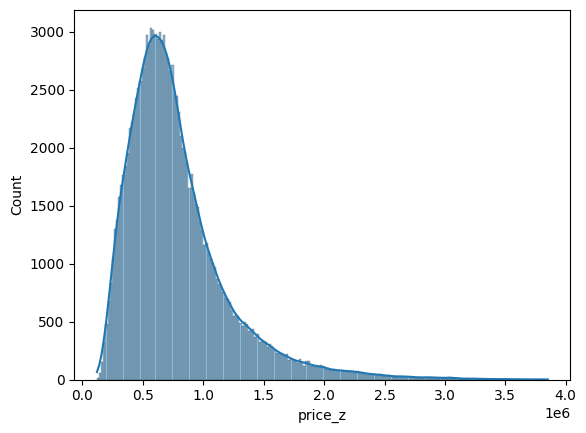

In [177]:
sns.histplot(df_train.price_z, kde=True)

<Axes: xlabel='price_z', ylabel='Count'>

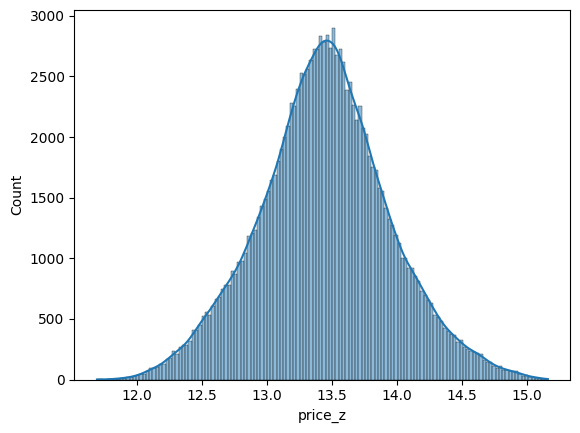

In [179]:
price_z_log = np.log(df_train.price_z + 1)
sns.histplot(price_z_log, kde=True)

## Feature Selection

In [184]:
numerical_variables

Index(['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built',
       'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post',
       'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'price_z',
       'market_volatility', 'infrastructure_quality',
       'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio',
       'estimated_maintenance_cost', 'global_economic_index'],
      dtype='object')

In [186]:
'''
Mutually correlated (irrelevant) variables
We can calculate correlations between numeric variables to identify redundant 
features (not always necessary - some methods are robust to the problem of 
multicollinearity)
'''

'\nMutually correlated (irrelevant) variables\nWe can calculate correlations between numeric variables to identify redundant \nfeatures (not always necessary - some methods are robust to the problem of \nmulticollinearity)\n'

In [188]:
train_numeric_correlations = df_train[numerical_variables].corr(method='pearson')

In [190]:
train_numeric_correlations

dim_m2   n_rooms  floor_no  floor_max  \
dim_m2                      1.000000  0.763315 -0.031711  -0.121481   
n_rooms                     0.763315  1.000000 -0.008416  -0.076762   
floor_no                   -0.031711 -0.008416  1.000000   0.602681   
floor_max                  -0.121481 -0.076762  0.602681   1.000000   
year_built                 -0.017163  0.000515  0.047493   0.113284   
dist_centre                 0.042537  0.050624 -0.038464  -0.038160   
n_poi                       0.033081  0.003567  0.051076   0.041347   
dist_sch                    0.062618  0.066284 -0.097236  -0.138220   
dist_clinic                 0.012848  0.037001 -0.120534  -0.174009   
dist_post                   0.053386  0.059298 -0.075338  -0.104344   
dist_kind                   0.065547  0.063354 -0.086440  -0.129102   
dist_rest                   0.031981  0.050383 -0.084027  -0.127068   
dist_uni                    0.031329  0.044804 -0.061090  -0.074735   
dist_pharma                 0.054454  0.061766 -0.097401  -0.135234   
price_z                     0.561631  0.472164  0.040283   0.033206   
market_volatility           0.546494  0.458800  0.039862   0.032871   
infrastructure_quality      0.019365  0.003094 -0.042634  -0.103100   
neighborhood_crime_rate    -0.000540 -0.000382 -0.002400   0.000684   
popularity_index            0.001525 -0.000444 -0.000028  -0.002758   
green_space_ratio          -0.039185 -0.043823  0.022600   0.018373   
estimated_maintenance_cost  0.692064  0.527586 -0.021681  -0.085468   
global_economic_index      -0.018613 -0.013422  0.010564   0.013749   

                            year_built  dist_centre     n_poi  dist_sch  \
dim_m2                       -0.017163     0.042537  0.033081  0.062618   
n_rooms                       0.000515     0.050624  0.003567  0.066284   
floor_no                      0.047493    -0.038464  0.051076 -0.097236   
floor_max                     0.113284    -0.038160  0.041347 -0.138220   
year_built                    1.000000     0.317382 -0.336712  0.235891   
dist_centre                   0.317382     1.000000 -0.445268  0.278545   
n_poi                        -0.336712    -0.445268  1.000000 -0.301550   
dist_sch                      0.235891     0.278545 -0.301550  1.000000   
dist_clinic                   0.226440     0.409324 -0.361136  0.543627   
dist_post                     0.212056     0.250915 -0.315894  0.737467   
dist_kind                     0.105896     0.125665 -0.204920  0.758560   
dist_rest                     0.151689     0.222394 -0.336751  0.748790   
dist_uni                      0.312366     0.491999 -0.424450  0.327756   
dist_pharma                   0.179730     0.241907 -0.295065  0.781748   
price_z                       0.105871     0.081847  0.176504 -0.000793   
market_volatility             0.102482     0.079934  0.171276 -0.000467   
infrastructure_quality       -0.918675    -0.286997  0.308818 -0.214555   
neighborhood_crime_rate       0.000091    -0.002293 -0.000054 -0.000504   
popularity_index             -0.002700     0.002459 -0.001438 -0.000579   
green_space_ratio            -0.269987    -0.826267  0.308762 -0.273349   
estimated_maintenance_cost   -0.011948     0.031395  0.020824  0.043695   
global_economic_index         0.001958     0.010575 -0.003935 -0.000134   

                            dist_clinic  dist_post  ...  dist_uni  \
dim_m2                         0.012848   0.053386  ...  0.031329   
n_rooms                        0.037001   0.059298  ...  0.044804   
floor_no                      -0.120534  -0.075338  ... -0.061090   
floor_max                     -0.174009  -0.104344  ... -0.074735   
year_built                     0.226440   0.212056  ...  0.312366   
dist_centre                    0.409324   0.250915  ...  0.491999   
n_poi                         -0.361136  -0.315894  ... -0.424450   
dist_sch                       0.543627   0.737467  ...  0.327756   
dist_clinic                    1.000000   0.48039

<Axes: >

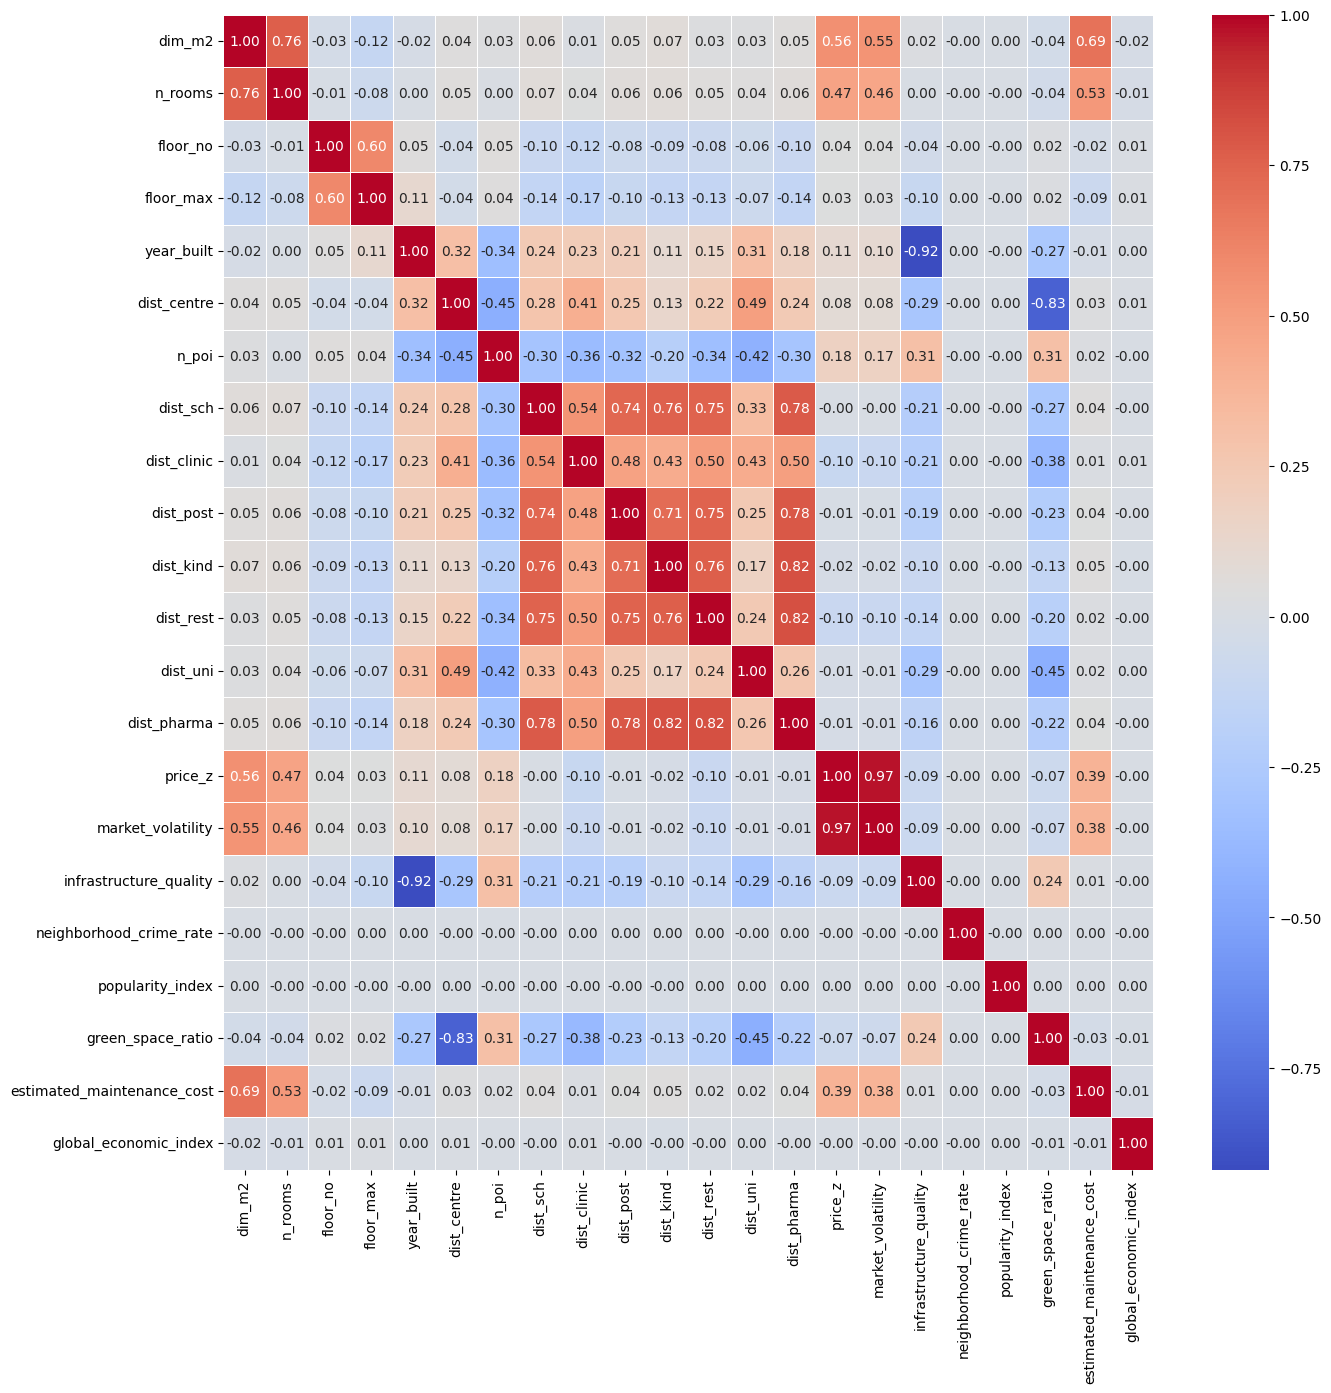

In [194]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_numeric_correlations,
            annot = True, 
            cmap = 'coolwarm', 
            fmt = '.2f',
            linewidths = 0.5)

In [196]:
mask = np.triu(np.ones_like(train_numeric_correlations, dtype=bool))
correlation_with_price_z = train_numeric_correlations.price_z.sort_values(ascending=False)
ordered_columns = correlation_with_price_z.index
train_numeric_correlations=train_numeric_correlations[ordered_columns].loc[ordered_columns]

<Axes: >

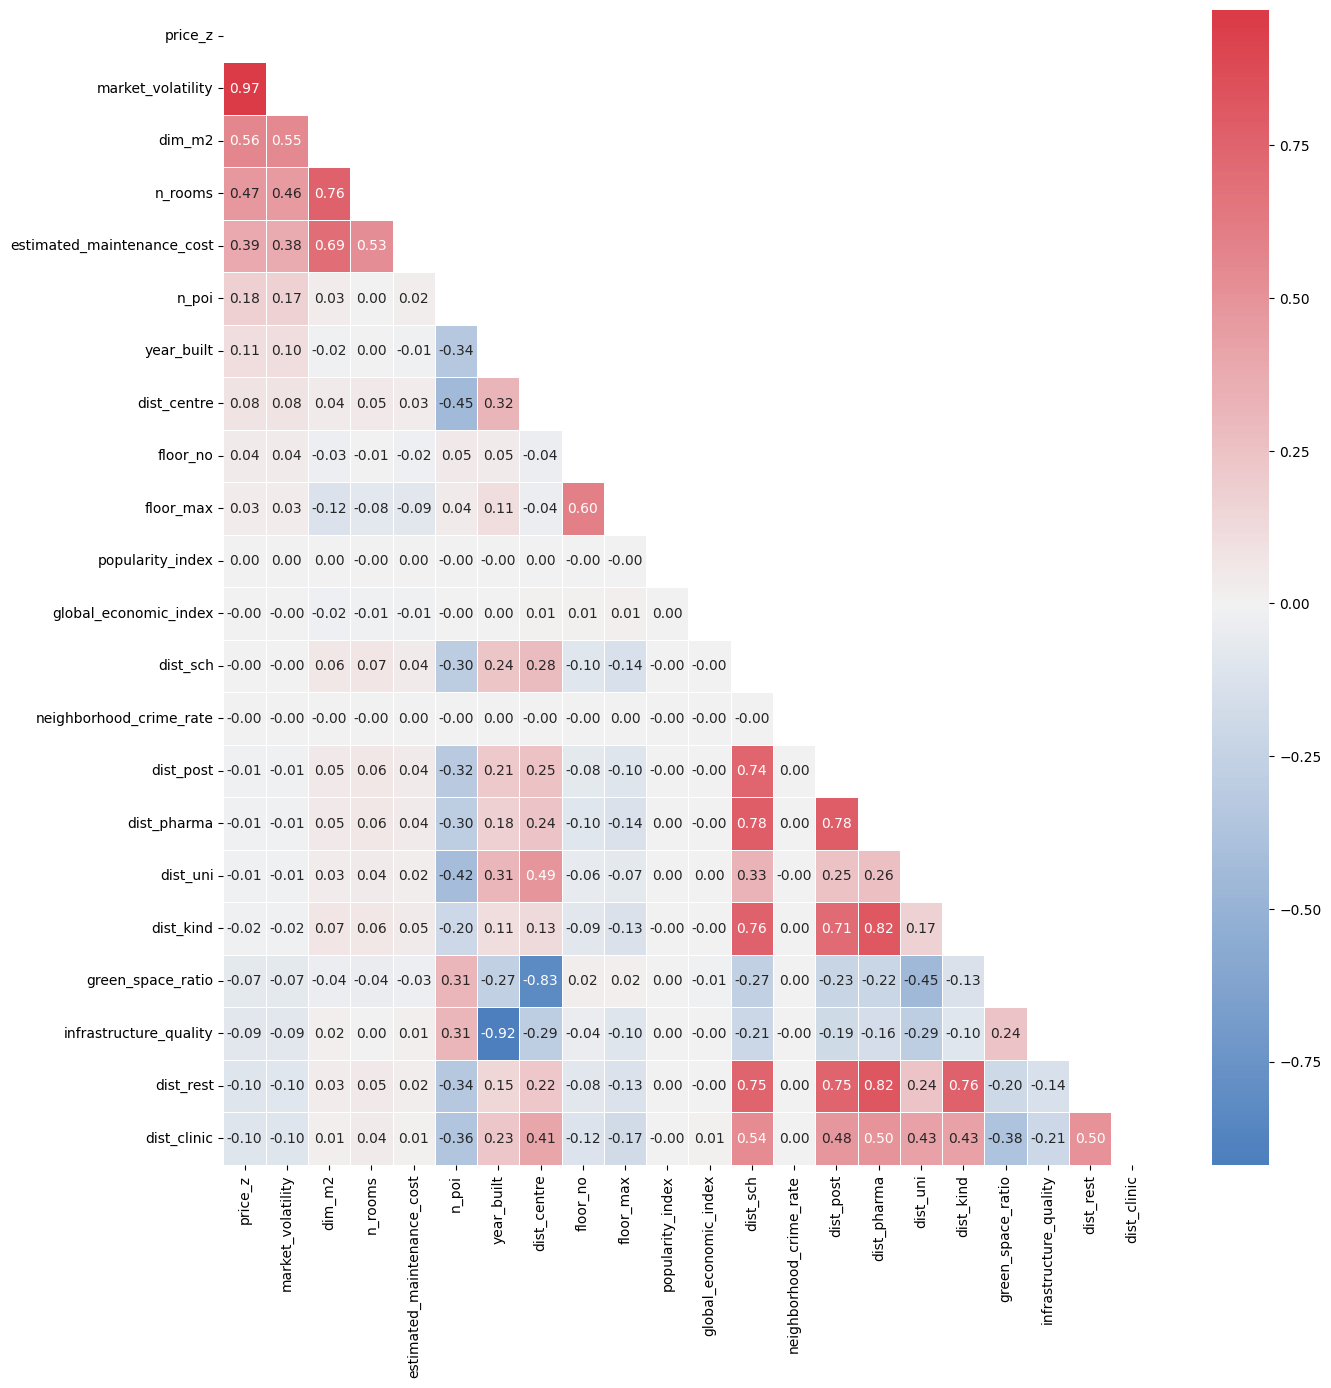

In [198]:
my_cmap = sns.diverging_palette(250, 10, as_cmap = True)
plt.figure(figsize=(15, 15))
sns.heatmap(train_numeric_correlations,
           annot = True,
           cmap = my_cmap,
           mask = mask,
           fmt = '.2f',
           linewidths = 0.5,
           # this argument ensures that the color map is centered at 0, 
           # meaning 0 will be displayed in white
           center = 0)

<Axes: >

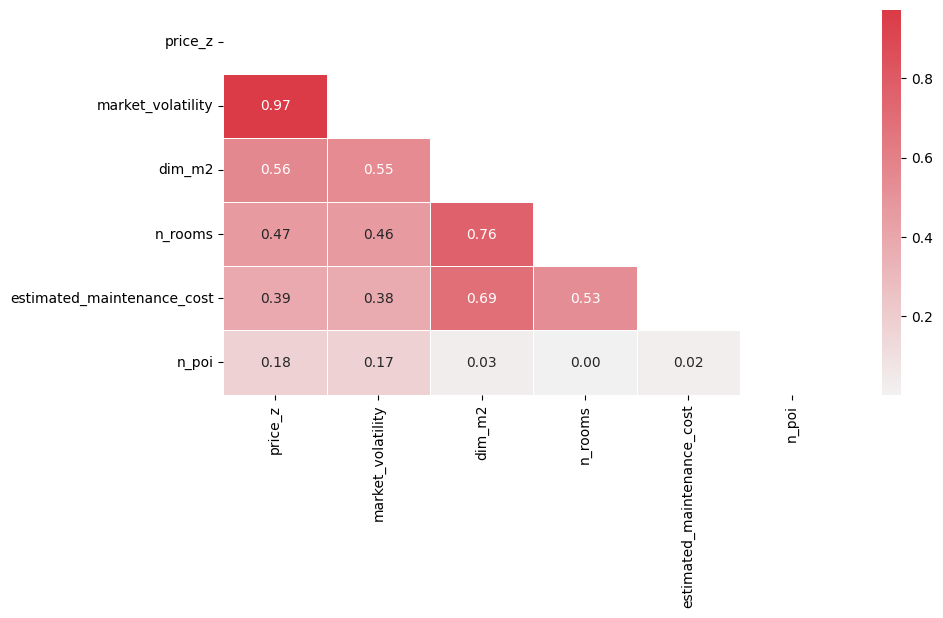

In [214]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_numeric_correlations.iloc[:6, :6],
            annot = True,
            cmap = my_cmap,
            mask = mask[:6, :6],
            fmt = '.2f',
            linewidths = 0.5,
            center = 0)

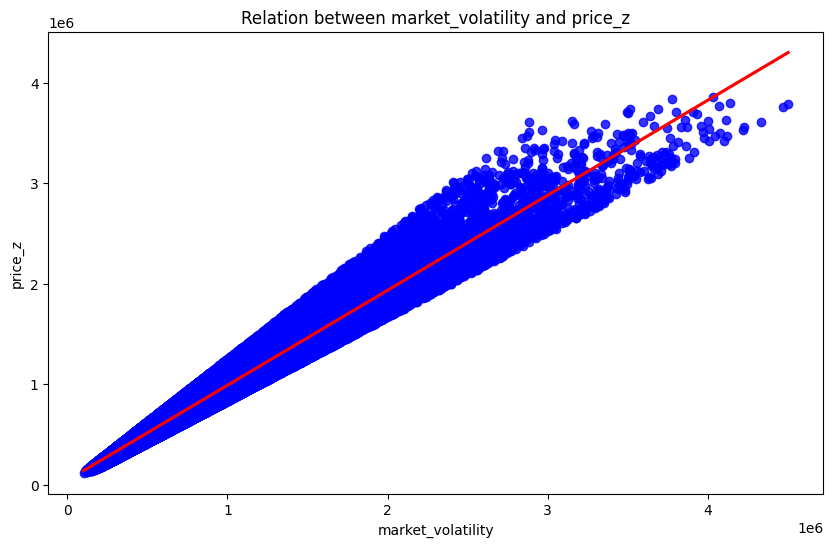

In [218]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'market_volatility', 
            y = 'price_z',
            data = df_train,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between market_volatility and price_z')
plt.xlabel('market_volatility')
plt.ylabel('price_z')
plt.show()

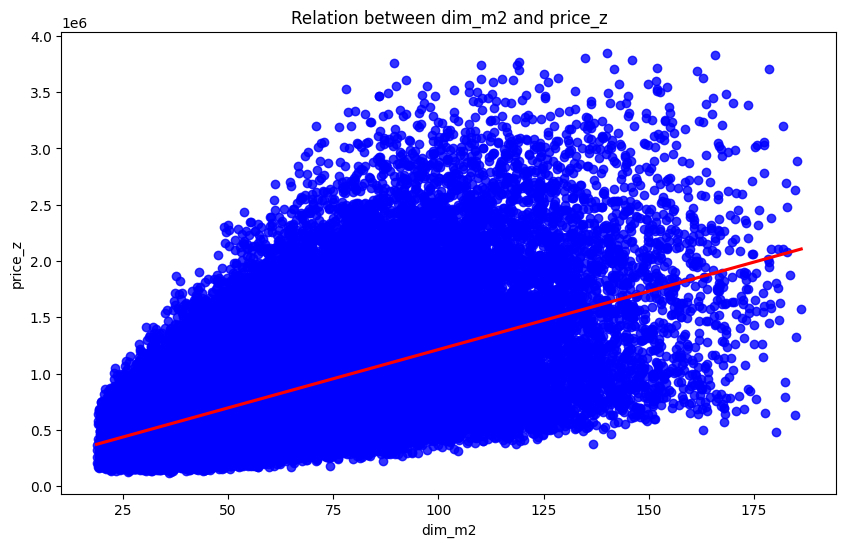

In [232]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'dim_m2', 
            y = 'price_z',
            data = df_train,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between dim_m2 and price_z')
plt.xlabel('dim_m2')
plt.ylabel('price_z')
plt.show()

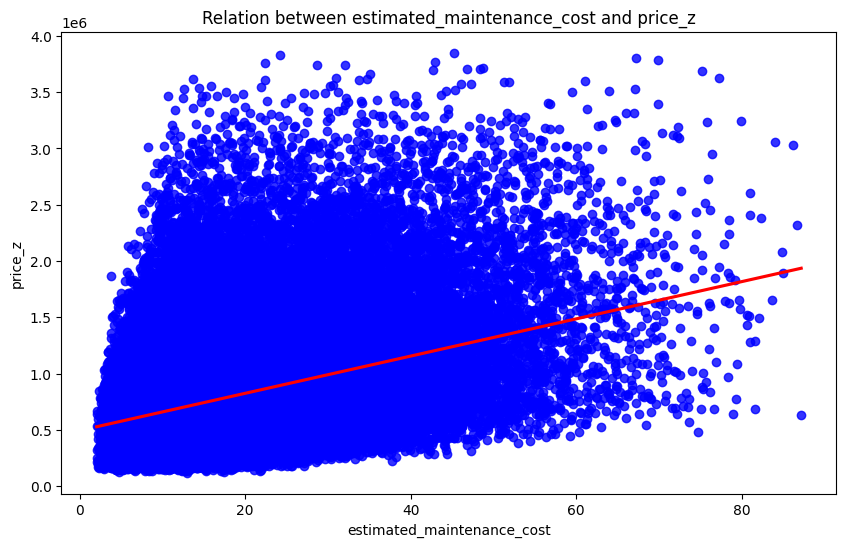

In [238]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'estimated_maintenance_cost', 
            y = 'price_z',
            data = df_train,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between estimated_maintenance_cost and price_z')
plt.xlabel('estimated_maintenance_cost')
plt.ylabel('price_z')
plt.show()

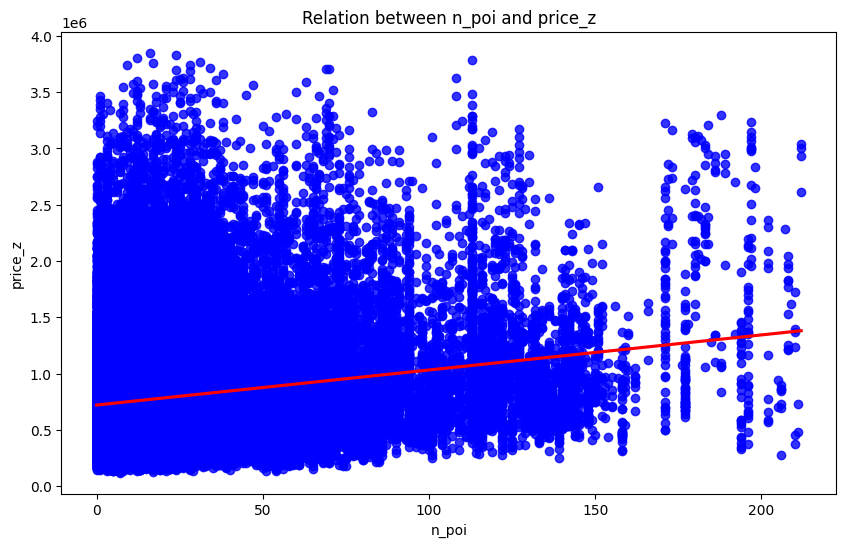

In [242]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'n_poi', 
            y = 'price_z',
            data = df_train,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between n_poi and price_z')
plt.xlabel('n_poi')
plt.ylabel('price_z')
plt.show()

In [250]:
simple_model = smf.ols('price_z ~ market_volatility + dim_m2 + n_rooms + n_poi', 
                      data = df_train).fit()

In [252]:
print(simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:                price_z   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 5.600e+05
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        06:30:36   Log-Likelihood:            -1.6168e+06
No. Observations:              125163   AIC:                         3.234e+06
Df Residuals:                  125158   BIC:                         3.234e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6067.3803    901.94